# Predicting Water and Power Usage for the city of Los Angeles, California

## An example project for PHY178/CSC171
### M. J. Madsen

I present here an example final project. This project is not intended to be a carbon-copy template for your project, but rather it should give you and idea of the general shape and style of work that I am looking for. Note that I am following the general outline and instructions for this sample project.

In [61]:
## Library Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from time import process_time
import seaborn as sns
sns.set_style("white")

# Preliminary Data Exploration

I am using data from the city of Los Angeles originally found from this website.

> https://data.lacity.org/A-Livable-and-Sustainable-City/Water-and-Electric-Usage-from-2005-2013/asvq-scwp

The dataset has four columns of interest:
1. The month in which the data was recorded
2. The zip code (geographical location) for the data
3. The water use for that zip code (measured in HCF)
4. The power use for that zip code (measure in kWh)

The raw data has another column (Value Date) that we will not be using. I first examine the raw data.

In [2]:
dfv1 = pd.read_csv("Water_and_Electric_Usage_from_2005_-_2013.csv")
dfv1.head(2)

Text Date Value Date                                         Zip Code  \
0  Mar_2008     Mar-08  90230\n(33.99506171100046, -118.39500957899969)   
1  Jul_2011     Jul-11  90272\n(34.04886156900045, -118.53572692799969)   

   Water Use  Power Use  
0      16.70        396  
1      35.73       1013

Before moving forward, there are some obvious data cleaning steps that need to be taken. I change the date from text to a datetime object and extract the 5-digit zip code from the Zip Code column. Finally, I drop the unneeded columns from the dataframe.

In [3]:
dfv1['Date'] = pd.to_datetime(dfv1["Text Date"], format="%b_%Y")
dfv1['Zip'] = dfv1['Zip Code'].str.extract("(.*)\n", expand=True).astype('int')
dfv2 = dfv1.drop(['Text Date', 'Value Date','Zip Code'],axis=1)
dfv2.head(2)

Water Use  Power Use       Date    Zip
0      16.70        396 2008-03-01  90230
1      35.73       1013 2011-07-01  90272

The goal of this project is to predict the water and power use. I plot the totals for each date.

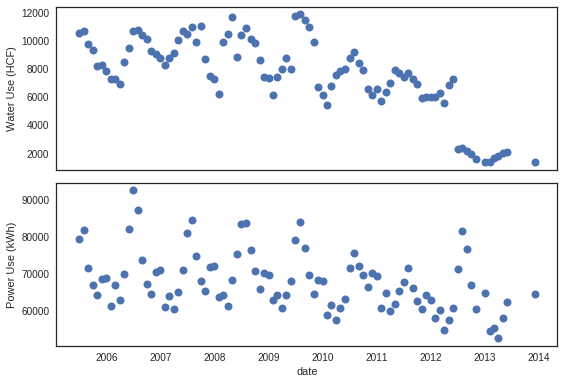

In [4]:
dfsum = dfv2.groupby('Date').sum()
dfsum.reset_index(inplace=True)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(dfsum['Date'], dfsum['Water Use'], marker='o', linestyle='', ms=8)
ax1.set_ylabel('Water Use (HCF)')

ax2.plot(dfsum['Date'], dfsum['Power Use'], marker='o', linestyle='', ms=8)
plt.xlabel('date')
ax2.set_ylabel('Power Use (kWh)')
plt.tight_layout()

# Data Cleaning

There is an extra point at the end that is separated from the rest of the dataset. I look specifically for times after Jan 1, 2013.

In [5]:
dfsum[dfsum['Date'] > pd.Timestamp('2013-01-01')]

Date  Water Use  Power Use       Zip
90 2013-02-01    1349.45      54265  13136208
91 2013-03-01    1640.86      55289  13136208
92 2013-04-01    1788.75      52367  13136208
93 2013-05-01    2037.96      57791  13136208
94 2013-06-01    2112.38      62299  13136208
95 2013-12-01    1398.03      64430  13136208

There are missing data points between July 2013 and November 2013. I cut the data off at June 30, 2013.

In [6]:
dfv3 = dfv2[dfv2['Date']<pd.Timestamp('2013-07-01')]
dfsum = dfv3.groupby('Date').sum()
dfsum.reset_index(inplace=True)

Before moving forward, it looks like there was a major change in water usage around the mid-point of 2012. However, when I look at the data grouped by zip code, I see that the drop is due to a change in the number of reported zip codes that happened in the middle of 2012. 

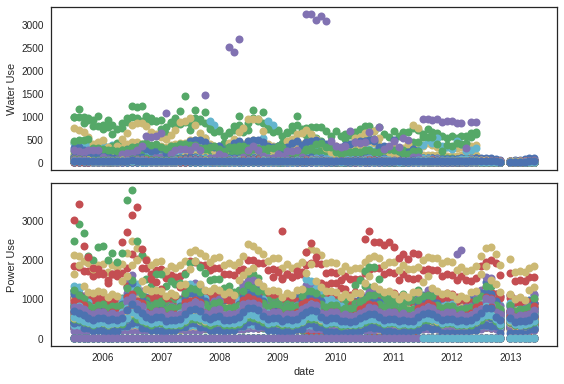

In [7]:
# Group data by zip code
groups = dfv3.groupby('Zip')

# Plot
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
for name, group in groups:
    ax1.plot(group['Date'], group['Water Use'], marker='o', linestyle='', ms=8, label=name)
    #ax.set_aspect(1)
    #break
#ax.legend(bbox_to_anchor=(1,0.5))

ax1.set_ylabel('Water Use')


ax2.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
for name, group in groups:
    ax2.plot(group['Date'], group['Power Use'], marker='o', linestyle='', ms=8, label=name)
    #ax.set_aspect(1)
    #break
#ax.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('date')
ax2.set_ylabel('Power Use')
plt.tight_layout()

Because my fits will be by zip code, this should not be an issue. However, there are a handfull of possible outliers in the water use data.

# Outlier Detection

I utilize the Mahalanobis distance to see how far from the average of the data the potential outliers are.

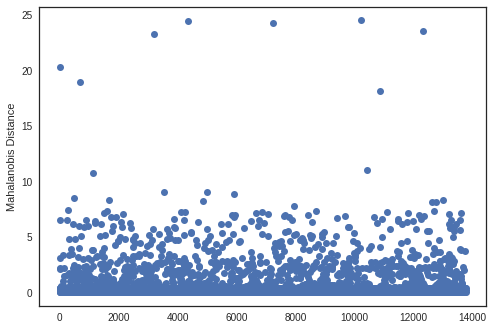

In [8]:
# Measure the mahalanobis distance.
X=dfv3[['Water Use']].values
emp_cov = EmpiricalCovariance().fit(X)
mahal_dist = np.sqrt(emp_cov.mahalanobis(X))

# Visualize the results
plt.plot(mahal_dist,marker='o',linestyle='')
plt.ylabel('Mahalanobis Distance')

There are about 8 points that stand out as being very far from the rest of the 12,000 points (over 15 standard deviations). All of the points occur in two short time periods in the same zip code.

In [9]:
dfv3["M_dist"] = mahal_dist
dfv3[dfv3["M_dist"]>15].sort_values('Date')

/projects/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Water Use  Power Use       Date    Zip     M_dist
683       2512.2          0 2008-03-01  91350  18.930970
10991     2407.0          0 2008-04-01  91350  18.121215
8         2694.8          0 2008-05-01  91350  20.336495
4406      3231.6          0 2009-07-01  91350  24.468400
10328     3235.6          0 2009-08-01  91350  24.499190
12452     3110.4          0 2009-09-01  91350  23.535489
7301      3202.4          0 2009-10-01  91350  24.243640
3227      3074.8          0 2009-11-01  91350  23.261465

There may have been something unusual happening during those time periods. I drop these points from the dataset as error outliers.

In [10]:
dfv4 = dfv3[dfv3["M_dist"]<15].drop('M_dist',axis=1).reset_index(drop=True)
dfv4.head(2)

Water Use  Power Use       Date    Zip
0      16.70        396 2008-03-01  90230
1      35.73       1013 2011-07-01  90272

# Data Enrichment

There is a definite month/year periodicity in the data. I add month and year data features to the model. I visualize the data to and see that the periodicity is clearly visible in both the water use and the power use data.

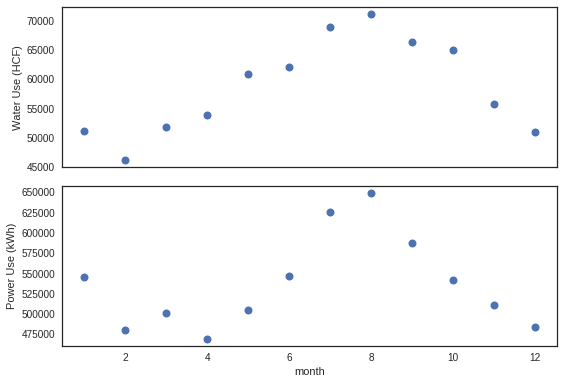

In [11]:
dfv4['Month'] = dfv4['Date'].apply(lambda x: x.month)
dfv4['Year'] = dfv4['Date'].apply(lambda x: x.year)

dfsum = dfv4.groupby('Month').sum()
dfsum.reset_index(inplace=True)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(dfsum['Month'], dfsum['Water Use'], marker='o', linestyle='', ms=8)
ax1.set_ylabel('Water Use (HCF)')

ax2.plot(dfsum['Month'], dfsum['Power Use'], marker='o', linestyle='', ms=8)
plt.xlabel('month')
ax2.set_ylabel('Power Use (kWh)')
plt.tight_layout()

Both the water and the power usage go up in the summer months, which makes sense. There is also a power spike in January that may be related to heating on cold days.

## Enriching Data with other Datasets

I hypothesize that the water and power useage depends on the following additional factors:
1) Population of each zip code
2) Economic status of each zip code (weath distribution)
3) Weather data

I join the original dataset with three additonal datasets to add these features.


### Adding Population Data

The population data was retrieved from the US Census Bureau.
> https://www.census.gov/geo/maps-data/data/zcta_rel_download.html

The dataset includes information about the population, the land area, and the total area for each zip code. There are a number of other columns of data that I will not use. I convert the zip code column (ZCTA5) to an integer in order to match the datatype of my power/water usage dataframe zip code.

In [12]:
dfzip = pd.read_csv("zcta_county_rel_10.txt",dtype={'ZCTA5':'object'})
dfzip['ZCTA5'] = dfzip['ZCTA5'].astype(int)
dfzip.head(2)

ZCTA5  STATE  COUNTY  GEOID  POPPT  HUPT     AREAPT  AREALANDPT   ZPOP  \
0    601     72       1  72001  18465  7695  165132671   164333375  18570   
1    601     72     141  72141    105    49    2326414     2326414  18570   

    ZHU      ...           COAREA  COAREALAND  ZPOPPCT  ZHUPCT  ZAREAPCT  \
0  7744      ...        173777444   172725651    99.43   99.37     98.61   
1  7744      ...        298027589   294039825     0.57    0.63      1.39   

   ZAREALANDPCT  COPOPPCT  COHUPCT  COAREAPCT  COAREALANDPCT  
0          98.6     94.77    94.71      95.03          95.14  
1           1.4      0.32     0.35       0.78           0.79  

[2 rows x 24 columns]

Because the data in this set are intended to merge other datasets, there are multiple entries for each zip code. The "Z" columns are totals for each zip code, so I only need one of them - I use the `max` aggregation. I  cut the unneeded columns, keeping only the zip code, population, total area, and land area columns. 

In [13]:
dfzipgroups = (dfzip[['ZCTA5','ZPOP','ZAREA','ZAREALAND']].groupby("ZCTA5").max())
dfzipgroups.reset_index(inplace=True)
dfzipgroups.head(2)

ZCTA5   ZPOP      ZAREA  ZAREALAND
0    601  18570  167459085  166659789
1    602  41520   83734431   79288158

To get a sense of the dataset, I look at the relationship between the land area and the population.

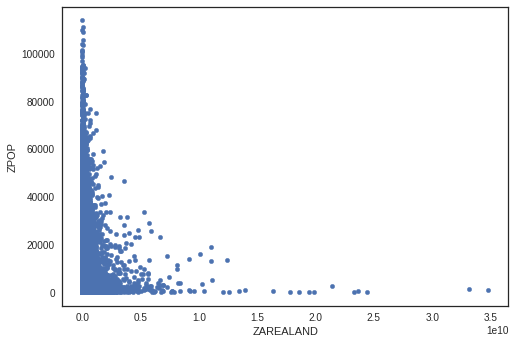

In [14]:
dfzipgroups.plot.scatter(x='ZAREALAND',y='ZPOP')

There is an interesting anti-correlation here. But perhaps that isn't too surprising, as larger population densities will have more zip codes associated with them, so most of the data would be in small land area, large populations.

Now I merge this will the resource use database, keeping only the columns that I need after the join. 

In [15]:
dfv5 = pd.merge(dfv4,dfzipgroups,left_on="Zip",right_on="ZCTA5")
print("{} rows lost in data merge.".format(len(dfv4.index)-len(dfv5.index)))
dfv5.drop(['ZCTA5'],axis=1,inplace=True)
dfv5.head(2)

950 rows lost in data merge.


Water Use  Power Use       Date    Zip  Month  Year   ZPOP     ZAREA  \
0      16.70        396 2008-03-01  90230      3  2008  31766  11785759   
1      17.59        407 2005-12-01  90230     12  2005  31766  11785759   

   ZAREALAND  
0   11672688  
1   11672688

There were a number of rows lost in the merge- these were zip codes that were not in the US Census database.

I graph the new inputs to see how the Water and Power use depend on them.

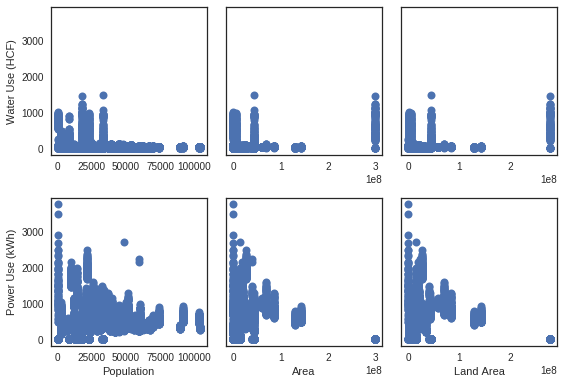

In [16]:
f, (ax1, ax2) = plt.subplots(2, 3, sharey=True)
ax1[0].plot(dfv5['ZPOP'], dfv5['Water Use'], marker='o', linestyle='', ms=8)
ax1[0].set_ylabel('Water Use (HCF)')
ax2[0].plot(dfv5['ZPOP'], dfv5['Power Use'], marker='o', linestyle='', ms=8)
ax2[0].set_ylabel('Power Use (kWh)')
ax2[0].set_xlabel('Population')

ax1[1].plot(dfv5['ZAREA'], dfv5['Water Use'], marker='o', linestyle='', ms=8)
ax2[1].plot(dfv5['ZAREA'], dfv5['Power Use'], marker='o', linestyle='', ms=8)
ax2[1].set_xlabel('Area')

ax1[2].plot(dfv5['ZAREALAND'], dfv5['Water Use'], marker='o', linestyle='', ms=8)
ax2[2].plot(dfv5['ZAREALAND'], dfv5['Power Use'], marker='o', linestyle='', ms=8)
ax2[2].set_xlabel('Land Area')

plt.tight_layout()


It looks like the power use is more strongly correlation with the census and land area data.

### Adding Economic Data

I add the economic data which is based on IRS tax records:
> https://www.irs.gov/uac/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi

This dataset has the following variables I am interested in:
* Nreturns: number of filed tax returns
* AGI: adjusted gross income (in thousands of \$)
* SW: Salary and Wages (in thousands of \$)
* EIC: total earned income tax credit (in thousands of \$)

However, the dataset is originally an Excel spreadsheet with multiple sheet names. I created a short function to retrieve the tax data I want.

In [17]:
def getTaxYear(year):
    # This function reads in a single sheet from the Excel document, then returns it as a dataframe.
    dftemp = pd.read_excel("allCAtaxdata2005-2013.xlsx",sheetname='{}'.format(year),thousands=",",na_values=["*","*              ",".","-"])
    dftemp['Zip Code'] = dftemp['Zip Code'].astype('int')
    dftemp['Year'] = year
    return dftemp

dftaxes = pd.concat([getTaxYear(x) for x in range(2005,2014)])
# Drop NaNs from data
dftaxes.dropna(inplace=True)

dftaxes.head(2)

Zip Code  Nreturns     AGI        SW      EIC  Year
0     90001     17313  406784  358687.0  16162.0  2005
1     90002     14712  331533  294916.0  16130.0  2005

I visualize the economic data in the following plot.

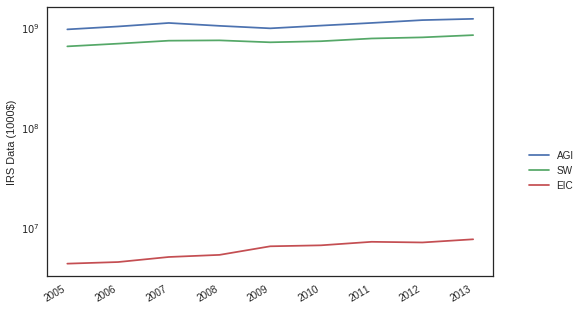

In [18]:
dfgroup = dftaxes.groupby('Year').sum()
dfgroup.reset_index(inplace=True)

plt.plot(dfgroup['Year'],dfgroup['AGI'],label='AGI')
plt.plot(dfgroup['Year'],dfgroup['SW'],label='SW')
plt.plot(dfgroup['Year'],dfgroup['EIC'],label='EIC')
plt.legend(bbox_to_anchor=(1.2,0.5))
plt.gca().set_yscale('log')
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.gcf().autofmt_xdate()
plt.ylabel('IRS Data (1000$)')

I merge the IRS dataset with the population and usage dataset.

In [19]:
dfv6 = pd.merge(dfv5,dftaxes,how="inner",left_on=["Zip","Year"],right_on=["Zip Code","Year"])
print("{} rows lost in data merge.".format(len(dfv5.index)-len(dfv6.index)))
dfv6.drop('Zip Code',axis=1,inplace=True)
dfv6.head(2)

190 rows lost in data merge.


Water Use  Power Use       Date    Zip  Month  Year   ZPOP     ZAREA  \
0      16.70        396 2008-03-01  90230      3  2008  31766  11785759   
1      20.95        368 2008-07-01  90230      7  2008  31766  11785759   

   ZAREALAND  Nreturns      AGI        SW     EIC  
0   11672688     15572  1008925  765127.0  3537.0  
1   11672688     15572  1008925  765127.0  3537.0

There is an additional data loss in this merge. However, I still have most of my original dataset.

In [20]:
print("Remaining data (from original dataset): {0:.1f}%".format(float(len(dfv6.index))/(len(dfv1.index))*100))

Remaining data (from original dataset): 90.7%


I visualize the combined dataset.

(0, 46370.0)

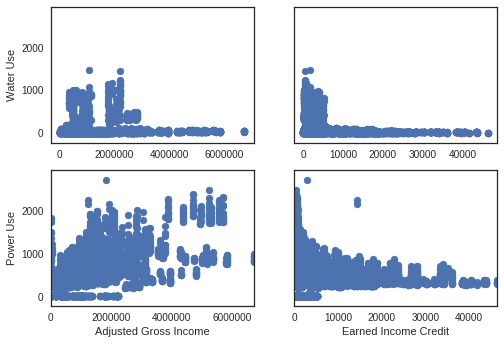

In [21]:
# Plot usage vs Adjusted Gross Income
f, (ax1, ax2) = plt.subplots(2, 2, sharey=True)

ax1[0].scatter(dfv6['AGI'],dfv6['Water Use'])
ax1[0].set_ylabel("Water Use")

ax2[0].scatter(dfv6['AGI'],dfv6['Power Use'])
ax2[0].set_ylabel("Power Use")
ax2[0].set_xlabel("Adjusted Gross Income")
ax2[0].set_xlim(0,max(dfv6['AGI']))

ax1[1].scatter(dfv6['EIC'],dfv6['Water Use'])
ax2[1].scatter(dfv6['EIC'],dfv6['Power Use'])
ax2[1].set_xlabel("Earned Income Credit")
ax2[1].set_xlim(0,max(dfv6['EIC']))

Again, there aren't strong correlations here, but the correlations that exist may improve the model. I am also interested in how closely this IRS dataset tracks the US Census dataset. The number of tax returns in a zip code should be close to the number of people living in that area. I plot the number of returns versus the census population to check this correlation.

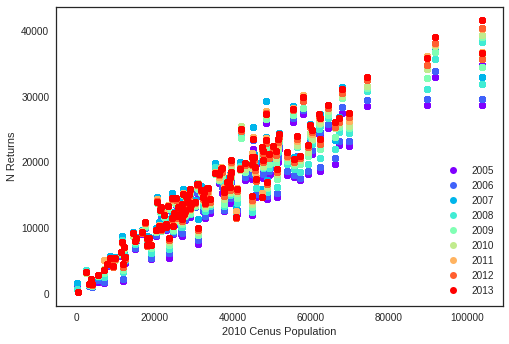

In [22]:
#We'll use a different tool to plot the data now that we know how to group the data by a category. This will help us make better combined plots later on.
groups = dfv6.groupby('Year')

# Plot
trainfig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(groups))))
for name, group in groups:
    ax.plot(group['ZPOP'],group['Nreturns'],'o',label=name,color=next(colors))
ax.legend(bbox_to_anchor=(1,0.5))
ax.set_ylabel('N Returns')
ax.set_xlabel('2010 Cenus Population')

The correlation is as expected. Howver, there is also a trend based on the year which probably corresponds to the growth and decline in populations.

### Adding Weather Data

I add historical weather data to my input features. This dataset comes from:

> https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GSOM

The dataset has the following variables:

* AWND: average wind speed (m/s)
* CLDD: cooling degree days
* HTDD: heating degree days
* PRCP: preciptiation (cm)
* TSUN: daily total sunshine
* TAVG: Average daily temperature (celsius) [Not Used]

The weather data is essentially the same for all of the zip codes in this dataset- they are all in the city of Los Angeles. Any small variation in the rain or temperature will be negligible because I only have the average over the full month of data.

In [23]:
weatherdf = pd.read_csv("LAX_weather.csv",parse_dates=[2])
weatherdf.fillna(0.0, inplace=True)
weatherdf['Date']=pd.to_datetime(weatherdf['DATE'])
weatherdf.drop(['STATION', 'NAME','DATE'],axis=1, inplace=True)
weatherdf.head(2)

AWND  CLDD   HTDD   PRCP  TAVG  TSUN       Date
0   3.2   4.8  135.2  174.5  14.1   0.0 2005-01-01
1   3.5   0.0  106.5  176.6  14.5   0.0 2005-02-01

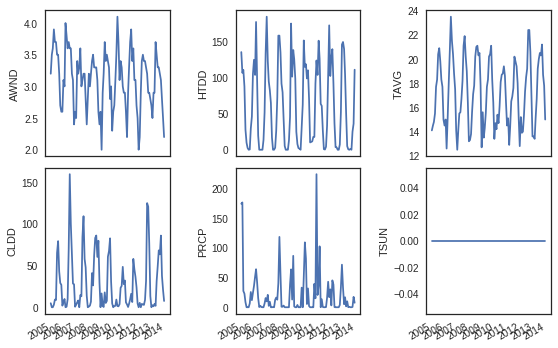

In [24]:

# Plot weather data
f, (ax1, ax2) = plt.subplots(2, 3, sharex=True)

ax1[0].plot(weatherdf['Date'],weatherdf['AWND'])
ax1[0].set_ylabel("AWND")
ax2[0].plot(weatherdf['Date'],weatherdf['CLDD'])
ax2[0].set_ylabel("CLDD")

ax1[1].plot(weatherdf['Date'],weatherdf['HTDD'])
ax1[1].set_ylabel("HTDD")
ax2[1].plot(weatherdf['Date'],weatherdf['PRCP'])
ax2[1].set_ylabel("PRCP")
ax1[2].plot(weatherdf['Date'],weatherdf['TAVG'])
ax1[2].set_ylabel("TAVG")
ax2[2].plot(weatherdf['Date'],weatherdf['TSUN'])
ax2[2].set_ylabel("TSUN")

plt.tight_layout()
plt.gcf().autofmt_xdate()


I merge this last dataset with my other features.

In [25]:
dfv7 = pd.merge(dfv6, weatherdf, on='Date')
print("{} rows lost in data merge.".format(len(dfv6.index)-len(dfv7.index)))
dfv7.drop(['TSUN'],axis=1,inplace=True)
dfv7.head(2)

0 rows lost in data merge.


Water Use  Power Use       Date    Zip  Month  Year   ZPOP     ZAREA  \
0      16.70        396 2008-03-01  90230      3  2008  31766  11785759   
1      30.18        970 2008-03-01  90272      3  2008  22986  60557886   

   ZAREALAND  Nreturns      AGI         SW     EIC  AWND  CLDD  HTDD  PRCP  \
0   11672688     15572  1008925   765127.0  3537.0   3.2   6.7  91.5   0.8   
1   59133992     11165  3569670  1750980.0   355.0   3.2   6.7  91.5   0.8   

   TAVG  
0  15.6  
1  15.6

There were weather data for all of the existing rows, so there wasn't any data lost in this step. I visualize the weather data and the water/power use data together to look for correlations.

(0, 224.19999999999999)

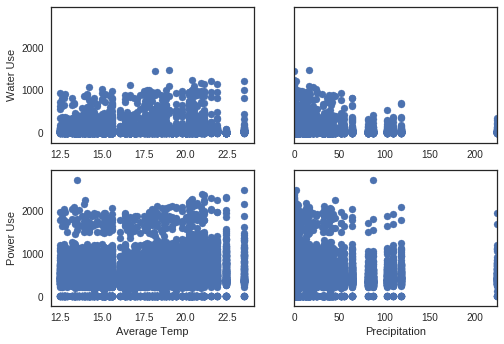

In [26]:
# Plot usage vs Adjusted Gross Income
f, (ax1, ax2) = plt.subplots(2, 2, sharey=True)

ax1[0].scatter(dfv7['TAVG'],dfv7['Water Use'])
ax1[0].set_ylabel("Water Use")

ax2[0].scatter(dfv7['TAVG'],dfv7['Power Use'])
ax2[0].set_ylabel("Power Use")
ax2[0].set_xlabel("Average Temp")


ax1[1].scatter(dfv7['PRCP'],dfv7['Water Use'])
ax1[1].set_xlim(0,max(dfv7['PRCP']))
ax2[1].scatter(dfv7['PRCP'],dfv7['Power Use'])
ax2[1].set_xlabel("Precipitation")
ax2[1].set_xlim(0,max(dfv7['PRCP']))

It certainly looks like there are correlations here - at least between the Water Use/Precepitation and the Power Use/Average Temp datasets.


# Data Transformations

## Categorical Data Transformation

I have three columns that are categorical in nature: Zip, Month, and Year. The other columns are continuous variables. I re-define these three variables as dummy variables.

In [27]:
zipdummy = pd.get_dummies(dfv7['Zip'],prefix='Z')
monthdummy = pd.get_dummies(dfv7['Month'],prefix='M')
yeardummy = pd.get_dummies(dfv7['Year'],prefix='Y')

dfv8 = dfv7.join(zipdummy).join(monthdummy).join(yeardummy)
dfv8.drop(['Date','Zip','Month','Year'],inplace=True,axis=1)
dfv8.head(2)

Water Use  Power Use   ZPOP     ZAREA  ZAREALAND  Nreturns      AGI  \
0      16.70        396  31766  11785759   11672688     15572  1008925   
1      30.18        970  22986  60557886   59133992     11165  3569670   

          SW     EIC  AWND   ...    M_12  Y_2005  Y_2006  Y_2007  Y_2008  \
0   765127.0  3537.0   3.2   ...       0       0       0       0       1   
1  1750980.0   355.0   3.2   ...       0       0       0       0       1   

   Y_2009  Y_2010  Y_2011  Y_2012  Y_2013  
0       0       0       0       0       0  
1       0       0       0       0       0  

[2 rows x 169 columns]

## Data test/training split
I split my data into 80% training and 20% testing data sets. I do this before doing any further data transformations in order to avoid "data snooping".

In [28]:
train, test = train_test_split(dfv8, test_size=0.2, random_state=23)

## Data Scaling

Almost all of my data columns are on different scales. I regularize the non-categorical data before fitting. Because only some of the columns need to be regularized, I split the data, regularize part of it, then re-join the training dataset. I do the same transformation to the test dataset.

In [29]:
# Fit the scaler
std_scaler = StandardScaler().fit(train.ix[:,2:14])

# Apply the transformation to the train and test datasets
train_std = pd.DataFrame(std_scaler.transform(train.ix[:,2:14]),columns=train.columns[2:14])
test_std = pd.DataFrame(std_scaler.transform(test.ix[:,2:14]),columns=test.columns[2:14])

# Recombine the scaled datasets
trainToMerge=train.reset_index(drop=True)
train_scaled=trainToMerge.ix[:,0:2].merge(train_std.merge(trainToMerge.ix[:,15:],left_index=True,right_index=True),left_index=True,right_index=True)

testToMerge=test.reset_index(drop=True)
test_scaled=testToMerge.ix[:,0:2].merge(test_std.merge(testToMerge.ix[:,15:],left_index=True,right_index=True),left_index=True,right_index=True)


I now separate out the features and the targets.


In [30]:
train_features = train_scaled.ix[:,2:].values
test_features = test_scaled.ix[:,2:].values

water_target = train_scaled['Water Use'].values
water_actual = test_scaled['Water Use'].values

power_target = train_scaled['Power Use'].values
power_actual = test_scaled['Power Use'].values

### PCA

I tested reducing the dimensionality of the features using the PCA. However, this did not improve either the model performance or the time it takes to fit the models. So I will not be using PCA for this analysis.

# Model Testing

My first model is to simply use the "prior year" data in order to predict the usage. I am using the Root-Mean-Square (RMS) as my metric for model performance. The RMS value gives me an estimate of the prediction error in the same units as the Water/Power use data.

In [188]:
dfoffset = dfv4
dfoffset['Prior Year'] = dfoffset['Year'].apply(lambda year: year - 1)

df_new = dfv4.merge(dfoffset, left_on=['Prior Year', 'Month','Zip'], right_on=['Year','Month','Zip'],suffixes=['','_Prior'])
df_new.drop(['Year_Prior','Prior Year_Prior','Prior Year'],inplace=True,axis=1)
print("{} rows lost in data merge.".format(len(dfv4.index)-len(df_new.index)))

1748 rows lost in data merge.


In [189]:
print("Water RMS Error: {0:.3f} for 'Last-year' Model".format( np.sqrt(np.mean( (df_new['Water Use'].values - df_new['Water Use_Prior'].values)**2)) ))
print("Power RMS Error: {0:.3f} for 'Last-year' Model".format( np.sqrt(np.mean( (df_new['Power Use'].values - df_new['Power Use_Prior'].values)**2)) ))

Water RMS Error: 62.052 for 'Last-year' Model
Power RMS Error: 139.855 for 'Last-year' Model


## Linear Regression
I next create a baseline predictive model using a linear regression using the same metrics

Water RMS Error: 44.844 for LinearRegression
Power RMS Error: 85.875 for LinearRegression
Fit Time: 1.3261661869999983 seconds
Predict Time: 0.01653146099999958 seconds


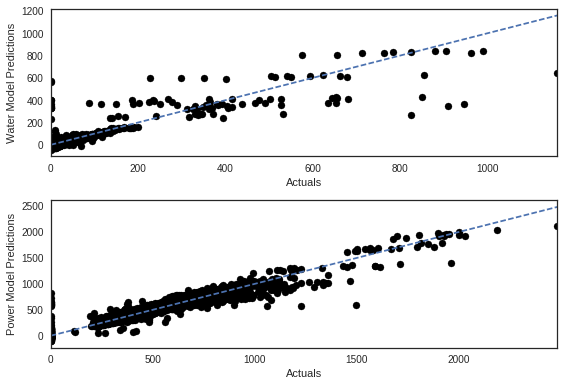

In [31]:
def fitAndPlot(train_features, test_features, model, **extraArgs):

    # Create linear regression objects for water and power
    water_model= model(**extraArgs)
    power_model= model(**extraArgs)
    
    # Timing
    start = process_time()
    # Fit the data
    water_model.fit(train_features,water_target)
    power_model.fit(train_features,power_target)
    fit_time = process_time() - start
    
    start = process_time()
    # Get the predictions
    wpredictions = water_model.predict(test_features)
    ppredictions = power_model.predict(test_features)
    predict_time = process_time() - start

    # Plot the actuals and the predictions
    f, (ax1, ax2) = plt.subplots(2, 1)

    ax1.scatter(water_actual, wpredictions, color='black')
    ax1.set_ylabel('Water Model Predictions')
    ax1.set_xlabel('Actuals')
    ax1.set_xlim(0,max(water_actual))
    #Plot the slope=1 line for reference
    X=np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
    ax1.plot(X,X,linestyle='--')

    ax2.scatter(power_actual, ppredictions, color='black')
    ax2.set_ylabel('Power Model Predictions')
    ax2.set_xlabel('Actuals')
    ax2.set_xlim(0,max(power_actual))
    #Plot the slope=1 line for reference
    X=np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], 100)
    ax2.plot(X,X,linestyle='--')
    plt.tight_layout()

    # Get the RMS values
    print("Water RMS Error: {0:.3f} for {1}".format( np.sqrt(np.mean((wpredictions - water_actual) ** 2)),model.__name__))
    print("Power RMS Error: {0:.3f} for {1}".format( np.sqrt(np.mean((ppredictions - power_actual) ** 2)),model.__name__))
    print("Fit Time: {} seconds".format(fit_time))
    print("Predict Time: {} seconds".format(predict_time))
    
    
    return (water_model, power_model)

water_model,power_model = fitAndPlot(train_features, test_features,LinearRegression)

The linear regression model is already performing better than the 'last year' model. I follow this with further regression models.


## Random Forest Regression
I next apply the random forest regression using the same train/test data.

Water RMS Error: 32.742 for RandomForestRegressor
Power RMS Error: 66.054 for RandomForestRegressor
Fit Time: 82.216455096 seconds
Predict Time: 0.30887336899999696 seconds


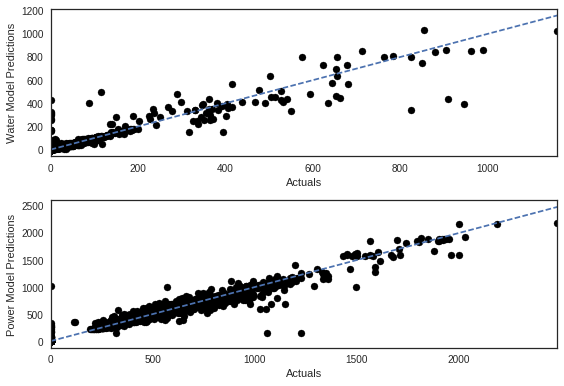

In [32]:
water_model,power_model = fitAndPlot(train_features,test_features, RandomForestRegressor, n_estimators=300, min_samples_leaf=10,random_state=32)

The random forest has better performance than the linear model, though it took significantly longer.

## Adaboost Regression

I look at two other models. First, the Adaboost ensemble method using the Decision Tree Regressor as the base model.

Water RMS Error: 31.656 for AdaBoostRegressor
Power RMS Error: 57.677 for AdaBoostRegressor
Fit Time: 74.75545528799921 seconds
Predict Time: 0.4766953270009253 seconds


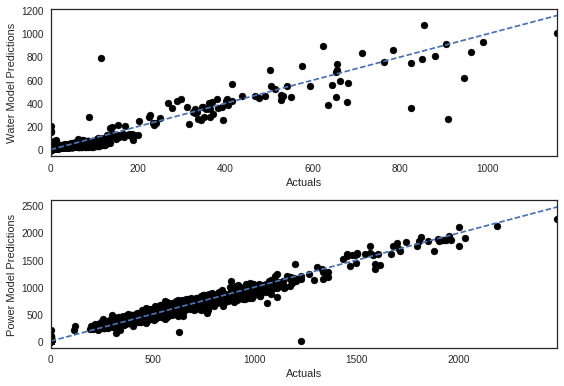

In [59]:
water_model2,power_model2 = fitAndPlot(train_features, test_features, AdaBoostRegressor, base_estimator=DecisionTreeRegressor(min_samples_leaf=10), n_estimators=300,random_state=32,loss='square')

The performance and timing are both slightly better than the Random forest model. One final model:

## Gradient Boosting Regressor

      Iter       Train Loss   Remaining Time 
         1        9026.1864            5.67m
         2        7532.4162            5.65m
         3        6313.0380            5.65m
         4        5318.0338            5.74m
         5        4502.7267            5.72m
         6        3838.5703            5.78m
         7        3295.1466            5.66m
         8        2843.7231            5.65m
         9        2476.8513            5.72m
        10        2171.9484            5.71m
        20         879.0091            5.94m
        30         584.7577            6.20m
        40         440.3867            6.37m
        50         333.8454            6.53m
        60         262.5081            6.76m
        70         208.6896            6.76m
        80         167.7968            6.71m
        90         138.7181            6.69m
       100         116.2387            6.59m
       200          22.5917            5.50m
       300           5.2009            3.83m
       40

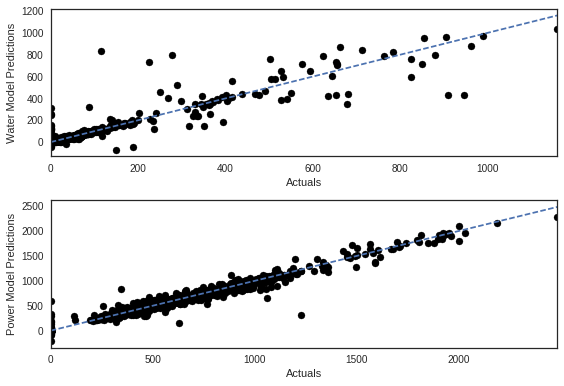

In [36]:
water_model3,power_model3 = fitAndPlot(train_features, test_features, GradientBoostingRegressor,min_samples_leaf=10, n_estimators=500,random_state=32,max_depth=200,verbose=1)

## Model Optimization

The Adaboost model has the best performance for the Water Use data, but the Gradient Boosting regressor has the best performance for the Power Use model. Because they are two separate datasets, I use the best performing model for each one and tune the hyperparameters separately.

### Water Use Model Hyperparameter Tuning

I tune the adaboost model hyperparameters, focusing on the minimum number of samples per leaf for the underlying decision tree regressor. I increased the number of estimators to reduce the noise in the trend data.

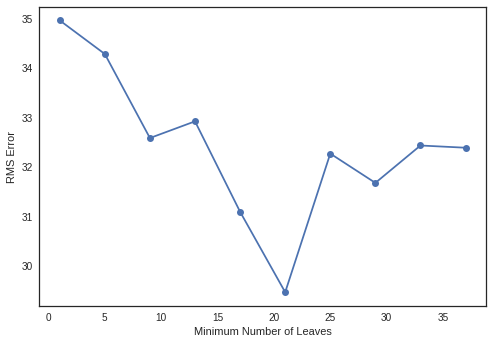

In [73]:
min_leaf_grid = range(1,41,4)
rms_scores = []
for  min_leaf in min_leaf_grid:
    # Create linear regression objects for water and power
    print("Working min_leaf {}".format(min_leaf))
    water_model= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(min_samples_leaf=min_leaf), n_estimators=1200,random_state=32,loss='square')

    # Timing
    start = process_time()
    # Fit the data
    water_model.fit(train_features,water_target)
    fit_time = process_time() - start

    start = process_time()
    # Get the predictions
    wpredictions = water_model.predict(test_features)
    predict_time = process_time() - start
    rms_score = np.sqrt(np.mean((wpredictions - water_actual) ** 2))
    rms_scores.append(rms_score)

plt.plot(min_leaf_grid, rms_scores,marker='o')
plt.xlabel("Minimum Number of Leaves")
plt.ylabel("RMS Error")

The best model performance comes around a minimum leaf size of 20. The model is overfitting with a smaller minimum leaf size and is underfitting with a larger minimum leaf size. Therefore, I run one final model for the water use data.

Water RMS Error: 31.016 for Adaboost Regressor
Fit Time: 90.67291085299985 seconds
Predict Time: 0.774193978000767 seconds


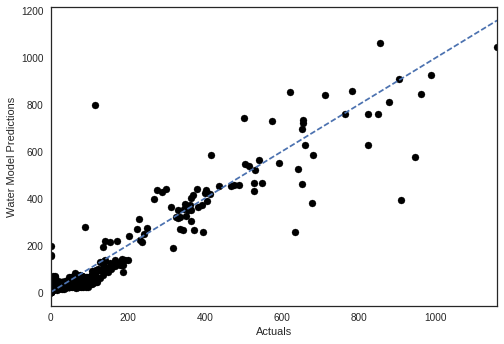

In [75]:
final_water_model= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(min_samples_leaf=20), n_estimators=1200,random_state=32,loss='square')
# Timing
start = process_time()
# Fit the data
final_water_model.fit(train_features,water_target)
fit_time = process_time() - start

start = process_time()
# Get the predictions
wpredictions = final_water_model.predict(test_features)
predict_time = process_time() - start
rms_score = np.sqrt(np.mean((wpredictions - water_actual) ** 2))

plt.scatter(water_actual, wpredictions, color='black')
ax1 = plt.gca()
ax1.set_ylabel('Water Model Predictions')
ax1.set_xlabel('Actuals')
ax1.set_xlim(0,max(water_actual))
#Plot the slope=1 line for reference
X=np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
ax1.plot(X,X,linestyle='--')

# Get the RMS values
print("Water RMS Error: {0:.3f} for Adaboost Regressor".format( np.sqrt(np.mean((wpredictions - water_actual) ** 2))))
print("Fit Time: {} seconds".format(fit_time))
print("Predict Time: {} seconds".format(predict_time))


### Power Use Model Optimization

I change to the Gradient Booting regression to optimize a model for predicting the power use. I again focus on tuning the minimum number of leaves hyperparameter.

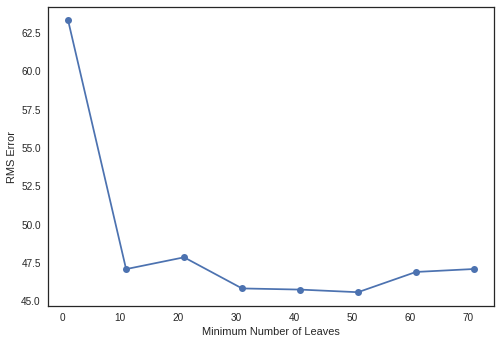

In [90]:

min_leaf_grid = range(1,81,10)
rms_scores = []
for  min_leaf in min_leaf_grid:
    # Create linear regression objects for water and power
    print("Working min_leaf {}".format(min_leaf))
    power_model= GradientBoostingRegressor(min_samples_leaf=min_leaf, n_estimators=500,random_state=32,max_depth=200)

    # Timing
    start = process_time()
    # Fit the data
    power_model.fit(train_features,power_target)
    fit_time = process_time() - start

    start = process_time()
    # Get the predictions
    ppredictions = power_model.predict(test_features)
    predict_time = process_time() - start
    rms_score = np.sqrt(np.mean((ppredictions - power_actual) ** 2))
    rms_scores.append(rms_score)

plt.plot(min_leaf_grid, rms_scores,marker='o')
plt.xlabel("Minimum Number of Leaves")
plt.ylabel("RMS Error")

plt.plot(min_leaf_grid, rms_scores,marker='o')
plt.xlabel("Minimum Number of Leaves")
plt.ylabel("RMS Error")

Again, there is evidence that, for a minimum leaf size of less than 30, the model is overfitting. There is a soft minimum around 40 before the model underfits the data, so I use that parameter to train a final Power Use model.

Power RMS Error: 45.757 for Gradient Boosting Regressor
Fit Time: 256.22809825200056 seconds
Predict Time: 0.16546982399995613 seconds


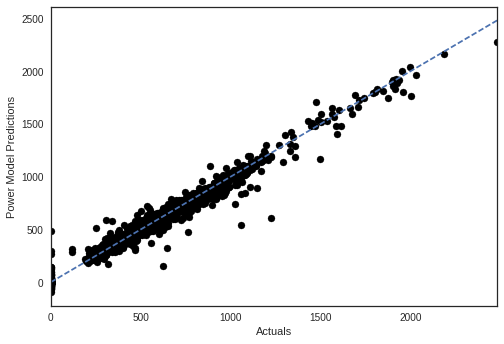

In [92]:
final_power_model= GradientBoostingRegressor(min_samples_leaf=40, n_estimators=500,random_state=32,max_depth=200)

# Timing
start = process_time()
# Fit the data
final_power_model.fit(train_features,power_target)
fit_time = process_time() - start

start = process_time()
# Get the predictions
ppredictions = final_power_model.predict(test_features)
predict_time = process_time() - start

plt.scatter(power_actual, ppredictions, color='black')
ax1 = plt.gca()
ax1.set_ylabel('Power Model Predictions')
ax1.set_xlabel('Actuals')
ax1.set_xlim(0,max(power_actual))
#Plot the slope=1 line for reference
X=np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
ax1.plot(X,X,linestyle='--')

# Get the RMS values
print("Power RMS Error: {0:.3f} for Gradient Boosting Regressor".format( np.sqrt(np.mean((ppredictions - power_actual) ** 2))))
print("Fit Time: {} seconds".format(fit_time))
print("Predict Time: {} seconds".format(predict_time))

### Model Limitations
I investigate the limitations of each model - where do the models disagree from the actual data? I plot the residuals for the Water Use model first.

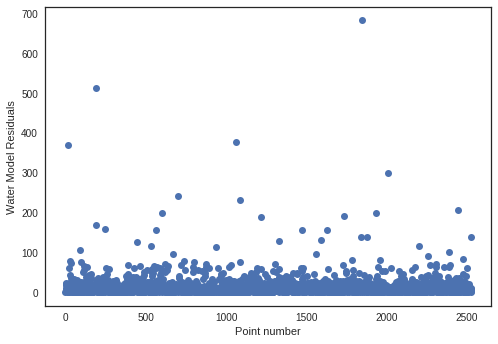

In [153]:
water_residuals = np.abs(wpredictions - water_actual)
plt.plot(water_residuals,marker='o',linestyle='')
plt.xlabel("Point number")
plt.ylabel("Water Model Residuals")

I investigate all points with a residual greater than 150.

In [151]:
water_poor_fit=dfv7.ix[test.index[water_residuals > 150]]
water_poor_fit['Model Predictions']=wpredictions[water_residuals > 150]
water_poor_fit

Water Use  Power Use       Date    Zip  Month  Year   ZPOP      ZAREA  \
9691      945.00          0 2011-07-01  91350      7  2011  33348   43948937   
3839      908.40          0 2012-01-01  91350      1  2012  33348   43948937   
18        415.00          0 2008-03-01  91201      3  2008  22781    6143646   
2110      277.00          0 2005-10-01  91350     10  2005  33348   43948937   
508       574.48          0 2008-02-01  90071      2  2008     15     319155   
2942        0.00          0 2012-11-01  90211     11  2012   8434    1813980   
682       501.00          0 2008-04-01  91201      4  2008  22781    6143646   
8095      634.50          0 2007-01-01  91350      1  2007  33348   43948937   
8928      622.00          0 2007-02-01  90265      2  2007  18116  298041072   
8893       88.60          0 2007-11-01  91350     11  2007  33348   43948937   
10655       0.00          0 2011-11-01  91201     11  2011  22781    6143646   
10522       0.00          0 2011-12-01  91201     12  2011  22781    6143646   
6233      652.80          0 2010-08-01  91350      8  2010  33348   43948937   
10356     115.00          0 2011-06-01  91350      6  2011  33348   43948937   
284       825.00          0 2008-12-01  90211     12  2008   8434    1813980   
551       679.00          0 2008-01-01  90265      1  2008  18116  298041072   
152       854.67          0 2008-07-01  90265      7  2008  18116  298041072   

       ZAREALAND  Nreturns      AGI        SW     EIC  AWND  CLDD   HTDD  \
9691    43886336     15077  1093595  908039.0  2387.0   3.6  57.9    0.8   
3839    43886336     15400  1158979  958999.0  2508.0   2.2   5.3  102.1   
18       6116160     10115   494601  369000.0  3797.0   3.2   6.7   91.5   
2110    43886336     13548   877019  743564.0  1370.0   2.7  29.1   29.4   
508       319155       639   364405   75762.0    33.0   3.0   2.0  134.7   
2942     1813980      5240   977691  477587.0   947.0   2.8  13.4   52.1   
682      6116160     10115   494601  369000.0  3797.0   3.4  40.9   79.6   
8095    43886336     15114  1073120  870460.0  1539.0   2.5   3.0  184.2   
8928   279184812      7969  2185356  748069.0   480.0   3.4   5.9  122.7   
8893    43886336     15114  1073120  870460.0  1539.0   2.4  13.7   72.2   
10655    6116160     10399   525338  394901.0  5178.0   2.5   4.5  102.2   
10522    6116160     10399   525338  394901.0  5178.0   2.0   0.0  172.2   
6233    43886336     14655  1054878  876876.0  2352.0   3.3  25.6   11.6   
10356   43886336     15077  1093595  908039.0  2387.0   3.4   6.2   26.7   
284      1813980      5438   894757  471144.0   780.0   2.6   0.0  174.7   
551    279184812      7837  1771931  682034.0   533.0   3.2   0.8  158.0   
152    279184812      7837  1771931  682034.0   533.0   3.3  83.0    0.0   

        PRCP  TAVG  Model Predictions  
9691     0.0  20.2         574.852632  
3839    30.2  15.2         394.325714  
18       0.8  15.6         583.333333  
2110    25.7  18.3         434.602727  
508     55.2  13.8         730.676563  
2942    33.4  17.0         198.000000  
682      0.8  17.1         742.842105  
8095     9.9  12.5         256.880656  
8928    20.9  14.2         853.484516  
8893    12.7  16.4         278.685714  
10655   43.0  15.1         156.121212  
10522   17.0  12.8         156.883721  
6233     0.0  18.8         460.494444  
10356    0.5  17.6         797.615227  
284     63.8  12.7         625.862069  
551    118.5  13.3         380.111111  
152      0.0  21.0        1060.796800

Most of these points where the model does a poor job fitting the data come from only a handful of zip codes: 91350, 91201, 91265, and 90211. There may be other events or other unique problems with these locations that caused the model predictions to not match the actuals.

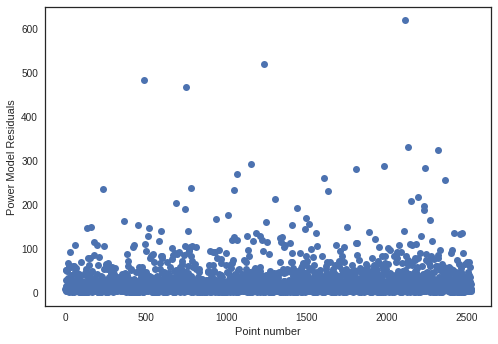

In [154]:
power_residuals = np.abs(ppredictions - power_actual)
plt.plot(power_residuals,marker='o',linestyle='')
plt.xlabel("Point number")
plt.ylabel("Power Model Residuals")


In the power model case, I investigate points where the residuals are greater than 200.

In [156]:
power_poor_fit=dfv7.ix[test.index[power_residuals > 200]]
power_poor_fit['Model Predictions']=ppredictions[power_residuals > 200]
power_poor_fit

Water Use  Power Use       Date    Zip  Month  Year   ZPOP     ZAREA  \
520        30.68        343 2008-02-01  90731      2  2008  59662  40481090   
2899        0.00          0 2012-08-01  91355      8  2012  32605  40487220   
9089       31.76       1107 2007-06-01  91307      6  2007  24474  20860392   
10879      16.83        626 2011-02-01  91355      2  2011  32605  40487220   
7196       31.10       2002 2013-01-01  90210      1  2013  21741  26383345   
3089        0.00       1081 2012-09-01  91205      9  2012  37810   4898344   
2762        0.00          0 2012-03-01  91210      3  2012    328    113997   
9594        0.00          0 2011-07-01  90245      7  2011  16654  15142094   
11008      30.00       1060 2011-05-01  91210      5  2011    328    113997   
842        68.58        885 2008-10-01  91302     10  2008  25709  69273356   
10172       5.00        254 2011-01-01  90275      1  2011  41804  43402847   
3186       39.22       1477 2012-09-01  91436      9  2012  14372  14891780   
2167       47.71       1025 2005-07-01  91324      7  2005  27669  11437330   
8838        0.00        765 2007-11-01  90403     11  2007  24525   3944526   
10343      34.50       1224 2011-06-01  91210      6  2011    328    113997   
5954       32.00       1494 2010-10-01  91210     10  2010    328    113997   
3871       68.34       2481 2006-07-01  90210      7  2006  21741  26383345   
1768       49.21       1055 2005-08-01  91324      8  2005  27669  11437330   
2513       22.42        310 2012-05-01  90731      5  2012  59662  40481090   
9815       12.00        648 2011-04-01  91355      4  2011  32605  40487220   
3896       50.47       1147 2006-07-01  91324      7  2006  27669  11437330   

       ZAREALAND  Nreturns      AGI         SW      EIC  AWND   CLDD   HTDD  \
520     23803092     23793  1149101   940785.0   9937.0   3.0    2.0  134.7   
2899    40079320     15080  1280204   950721.0   2222.0   3.2  124.7    0.0   
9089    20836532     11961  1019116   688451.0   1508.0   3.0   13.1   16.9   
10879   40079320     15155  1363894   941778.0   2212.0   2.9    0.3  151.0   
7196    26226245      9770  4939447  1504798.0    955.0   2.5    2.5  149.2   
3089     4897491     15790   594462   488257.0   9300.0   2.9  120.5    0.0   
2762      113997       200    31641    19477.0      0.0   3.4    4.0  139.3   
9594    14148053      9338   913373   669719.0   1191.0   3.6   57.9    0.8   
11008     113997       215    35619    20750.0      0.0   3.9   16.1   60.7   
842     69143126     12150  2315019  1324983.0    890.0   2.6   79.6   12.8   
10172   35004660     19040  2716592  1498530.0   1706.0   2.2    3.4  103.6   
3186    14751608      9180  3782435  1814704.0    499.0   2.9  120.5    0.0   
2167    11373551     11136   715075   438407.0   2909.0   3.5   65.1    2.5   
8838     3697303     15272  1707337   956655.0    836.0   2.4   13.7   72.2   
10343     113997       215    35619    20750.0      0.0   3.4    6.2   26.7   
5954      113997       187    23612    15682.0      0.0   2.9   27.6   17.7   
3871    26226245     10497  5238507  1638406.0    433.0   3.6  159.3    0.0   
1768    11373551     11136   715075   438407.0   2909.0   3.5   79.2    0.0   
2513    23803092     25280  1240957   981814.0  14301.0   3.4    2.8   36.5   
9815    40079320     15155  1363894   941778.0   2212.0   3.7    9.5   63.5   
3896    11373551     11373   705898   457689.0   2932.0   3.6  159.3    0.0   

       PRCP  TAVG  Model Predictions  
520    55.2  13.8         577.653810  
2899    0.0  22.4         482.980702  
9089    0.0  18.2         903.294856  
10879  37.4  12.9         158.648852  
7196   33.0  13.6        1764.628705  
3089    0.0  22.4         848.008836  
2762   45.3  14.0         268.884486  
9594    0.0  20.2         291.448270  
11008  13.5  16.9         538.781944  
842     0.0  20.5        1097.152344  
10172  20.6  15.1         513.265376  
3186    0.0  22.4        1706.908344  
2167    0.0  20.4     

The points where the power model fails are not as clearly grouped into a few locations, sizes, or any other obvious grouping. There may be a pattern where the HTDD or the CTDD are larger than typical, but that is not definitive.

## Model Feature Importances

Finally, I look at the feature importances for both the water and power use models.

Water Use Model Feature ranking:
1. Nreturns(3): 11.77(8.20)% 
2. EIC(6): 8.21(8.56)% 
3. SW(5): 7.51(6.84)% 
4. AGI(4): 6.47(5.93)% 
5. Z_91350(123): 5.84(5.94)% 
6. ZAREALAND(2): 5.70(8.04)% 
7. PRCP(10): 5.63(4.76)% 
8. ZAREA(1): 5.42(7.53)% 
9. CLDD(8): 5.08(3.83)% 
10. Z_90265(82): 4.66(8.24)% 
11. AWND(7): 3.92(3.22)% 
12. M_10(154): 3.49(5.20)% 
13. Z_91201(102): 3.45(3.08)% 
14. TAVG(11): 3.37(4.16)% 
15. HTDD(9): 3.32(5.07)% 
16. ZPOP(0): 2.97(3.98)% 
17. Z_90071(71): 2.48(2.81)% 
18. Y_2011(163): 1.63(3.84)% 
19. Y_2007(159): 1.44(3.80)% 
20. Y_2012(164): 1.39(3.38)% 
21. Y_2013(165): 1.06(2.60)% 


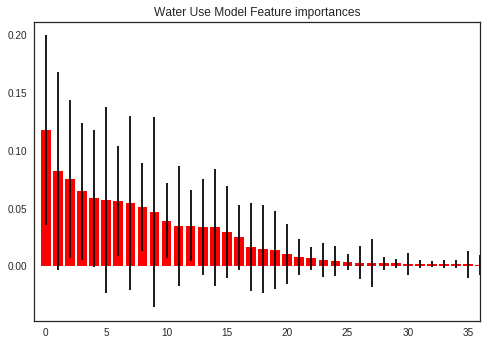

In [157]:
importances = final_water_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_water_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Water Use Model Feature ranking:")

ntop = 0
for f in range(train_features.shape[1]):
    if importances[indices[f]] > 0.01:
        ntop += 1
        print("{0:d}. {1:s}({4:d}): {2:.2f}({3:.2f})% ".format(f + 1, train_scaled.ix[:,2:].columns[indices[f]], importances[indices[f]]*100,std[indices[f]]*100,indices[f]))
plt.title("Water Use Model Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xlim([-1, 36])
plt.show()

The most important features for determining water use are: the number of people, the level of low-income houses, overall economic status, the size of the zip code (more importantly the land area), and the amount of precipitation. Those all agree with my original hypothesis that population, economics, and weather all play important roles in determining water use.

Power Use Model Feature ranking:
1. Nreturns(3): 16.03(13.83)% 
2. AGI(4): 13.29(9.80)% 
3. SW(5): 12.65(11.62)% 
4. EIC(6): 12.56(9.35)% 
5. ZAREA(1): 7.06(5.69)% 
6. ZAREALAND(2): 5.69(5.03)% 
7. ZPOP(0): 5.36(6.18)% 
8. HTDD(9): 3.57(5.41)% 
9. Z_90731(96): 3.25(3.84)% 
10. CLDD(8): 3.01(2.68)% 
11. TAVG(11): 2.40(2.82)% 
12. AWND(7): 2.11(2.02)% 
13. PRCP(10): 2.07(2.23)% 
14. Z_90046(54): 1.95(2.26)% 
15. Z_91355(125): 1.56(2.20)% 


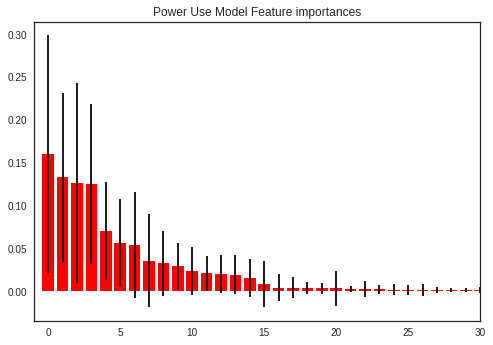

In [158]:
importances = final_power_model.feature_importances_
std = np.std([tree[0].feature_importances_ for tree in final_power_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Power Use Model Feature ranking:")

ntop = 0
for f in range(train_features.shape[1]):
    if importances[indices[f]] > 0.01:
        ntop += 1
        print("{0:d}. {1:s}({4:d}): {2:.2f}({3:.2f})% ".format(f + 1, train_scaled.ix[:,2:].columns[indices[f]], importances[indices[f]]*100,std[indices[f]]*100,indices[f]))
plt.title("Power Use Model Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xlim([-1, 30])
plt.show()

The most important features for the power use model are population, economics, land area, then heating degree days, cooling degree dyas, and average temperature. Again, these agree with my hypothesis.

In [297]:
# Miscellaneous Model Properties
print( "Model First Date: {}".format(dfv4['Date'].min()))
print( "Model Last Date: {}".format(dfv4['Date'].min()))
print("Total Zip Codes: {}".format(len(dfv4['Zip'].unique())))
print("Total Population: {} people".format(dfzipgroups[dfzipgroups['ZCTA5'].isin(dfv4['Zip'].unique())]['ZPOP'].sum()))

Model First Date: 2005-07-01 00:00:00
Model Last Date: 2005-07-01 00:00:00
Total Zip Codes: 145
Total Population: 4729404 people


I calculated the accuracy of both the water use and the power use models.

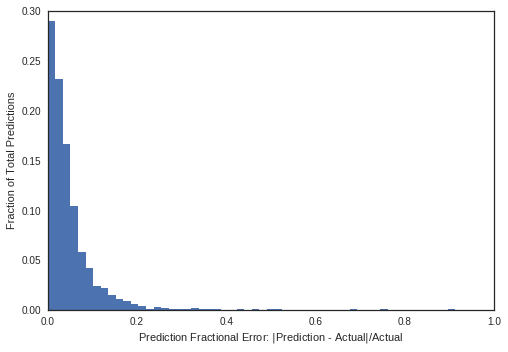

68% of the power use predictions have better than a 95% accuracy


In [272]:
nonzero = power_actual>0
power_accuracy = (ppredictions[nonzero] - power_actual[nonzero])/power_actual[nonzero]

x,bins,p= plt.hist(np.abs(power_accuracy),bins=100,normed=1)
plt.xlabel('Prediction Fractional Error: $|$Prediction - Actual$|$/Actual')
plt.ylabel('Fraction of Total Predictions')
for item in p:
    item.set_height(item.get_height()/sum(x))
plt.ylim(0,.3)
plt.xlim(0,1)
plt.show()

print("{0:.0f}% of the power use predictions have better than a 95% accuracy".format(float(len(np.extract(np.abs(power_accuracy) < 0.05,power_accuracy)))/len(power_accuracy)*100))

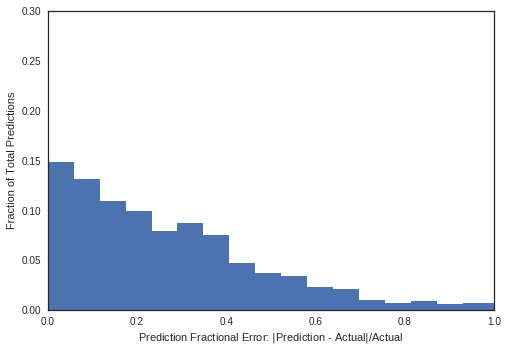

72% of the water use predictions have better than a 60% accuracy


In [298]:
nonzero = water_actual>0
water_accuracy = (wpredictions[nonzero] - water_actual[nonzero])/water_actual[nonzero]

x,bins,p= plt.hist(np.abs(water_accuracy),bins=200,normed=1)
plt.xlabel('Prediction Fractional Error: $|$Prediction - Actual$|$/Actual')
plt.ylabel('Fraction of Total Predictions')
for item in p:
    item.set_height(item.get_height()/sum(x))
plt.ylim(0,.3)
plt.xlim(0,1)
plt.show()

print("{0:.0f}% of the water use predictions have better than a 60% accuracy".format(float(len(np.extract(np.abs(water_accuracy) < 0.4,water_accuracy)))/len(water_accuracy)*100))

# Conclusion

I built machine learning models to predict the water use (in HCF) and power use (in kWh) for the city of Los Angeles. The models were based on data from July 2005 to June 2013. They cover the water and power usage for 145 different zip codes housing around 4.7 million people.

I compared a very simple initial model (that used the data from the previous year to predict the current month's usage) to machine learning models that utilize:
* The zip code
* The month and year
* US Census population and land area data
* IRS income tax return data (AGI, Salaries and Wages, and EIC)
* NOAA weather data (Heating- and cooling-degree days, average temperature, wind, and precipitation).

I measured the model performace using the root-mean-squared of the differece between the model's predictions and the actual usage for approximately 20% of the dataset, reserved as a set of test data.

The initial  model had the following RMS errors:

> Water Use prediction RMS Error: 62.052 for the 'Last-year' Model

> Power Use prediction RMS Error: 139.855 for the 'Last-year' Model

The best machine learning models had significantly improved meaures:

>Water Use prediction RMS Error: 31.016 using an Adaboost Regressor

>Power Use prediction RMS Error: 45.757 using a Gradient Boosting Regressor

Finally, I measured the relative error of the predictions of the machine learning models. This is calculated as

> $\frac{|\textrm{Predicted Usage} - \textrm{Actual Usage}|}{\textrm{Actual Usage}}$.

The power use model performed very well with 68% of the power use predictions scoring better than a 95% accuracy. The water use model did not perform quite as well; however, 72% of the water use predictions had better than a 60% accuracy.